In [2]:
from rdkit import Chem
from mordred import Calculator, descriptors
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [3]:
calc = Calculator(descriptors, ignore_3D=True)

def get_desc(smile):
    mol = Chem.MolFromSmiles(smile)
    return calc(mol)

#### Загрузка датасета

In [4]:
df1 = pd.read_csv('data/lc50_96h/LC50_96h.csv')
df2 = pd.read_csv('data/lc50_96h/LC50_test.csv')
df3 = pd.read_csv('data/lc50_96h/LC50_train.csv')
df = pd.concat([df1, df2, df3], axis=0).drop(columns=['filename']).groupby('smiles').mean().reset_index()
df

,smiles,label
0,BrC(Br)c1ccccc1C(Br)Br,5.985000
1,BrC1=C(Br)C=CC=C1,4.758851
2,BrC1=CC=C(Br)C=C1,5.279066
3,BrC1=CC=C(OC2=CC=CC=C2)C=C1,5.640765
4,BrC1=CC=CC=C1,4.444818
...,...,...
1239,c1ccc2occc2c1,3.926000
1240,c1ccc2scnc2c1,3.325000
1241,c1ccccc1,3.445000
1242,c1ccncc1,2.914000


In [5]:
X = np.array(list(map(lambda x: get_desc(x), df['smiles'])), dtype=float)
y = np.array(df['label'])

X.shape, y.shape

c:\Users\podov\Desktop\solution\venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


((1244, 1613), (1244,))

#### Пример молекулы

BrC(Br)c1ccccc1C(Br)Br


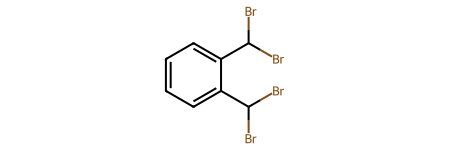

In [8]:
view = df.iloc[0]
view_mol = Chem.MolFromSmiles(view['smiles'])
print(view['smiles'])
view_mol

#### Разделение на обучающую и тренировочную выборки

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
def print_metrics(y_test, y_pred):
    print(
        f'MAE: {mean_absolute_error(y_test, y_pred)}\n'
        f'MSE: {mean_squared_error(y_test, y_pred)}\n'
        f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}\n'
        f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}\n'
        f'R^2: {r2_score(y_test, y_pred)}'
    )

## Tensorflow

In [32]:
X_tf = np.where(np.isnan(X), 0, X)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.33, random_state=42)

In [121]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="tanh", input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation="sigmoid"),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(250, activation="sigmoid"),
        tf.keras.layers.Dense(1, activation="selu"),
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
print(model.summary())
model.fit(X_train_tf, y_train_tf, epochs=25)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 100)               161400    
                                                                 
 dense_118 (Dense)           (None, 500)               50500     
                                                                 
 dropout_35 (Dropout)        (None, 500)               0         
                                                                 
 dense_119 (Dense)           (None, 250)               125250    
                                                                 
 dense_120 (Dense)           (None, 1)                 251       
                                                                 
Total params: 337,401
Trainable params: 337,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
27/27 [========================

In [99]:
y_pred_tf = model.predict(X_test_tf)
print_metrics(y_test_tf, y_pred_tf)

MAE: 0.8753326443962931
MSE: 1.2911098184078966
MAPE: 0.3752017521063106
RMSE: 1.136270134434544
R^2: 0.32592386427067777


## sklearn

### Проверили кросс-валидацию

In [124]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
r2 = []

for train_index, test_index in kfold.split(X, y):
    xgbr = XGBRegressor().fit(X[train_index], y[train_index])
    y_pred_xgbr = xgbr.predict(X[test_index])
    r2.append(r2_score(y[test_index], y_pred_xgbr))
    print('R^2:', r2[-1], end='\n\n')

print(np.mean(r2))

R^2: 0.652833174751903

R^2: 0.7749465274019718

R^2: 0.7433723151705549

R^2: 0.7288763698316083

R^2: 0.7378899385308839

0.7275836651373844


### XGB

In [35]:
xgbr = XGBRegressor().fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
print_metrics(y_test, y_pred_xgbr)

MAE: 0.44425541618219844
MSE: 0.5539231160844167
MAPE: 0.21262235313342798
RMSE: 0.7442601131892107
R^2: 0.7108020183428228


### CatBoost

In [19]:
cbr = CatBoostRegressor(border_count=128, depth=5).fit(X_train, y_train, verbose=False)
y_pred_cbr = cbr.predict(X_test)
print_metrics(y_test, y_pred_cbr)

MAE: 0.4277394773991986
MSE: 0.4589501183369997
MAPE: 0.19952045735277302
RMSE: 0.6774585731518937
R^2: 0.7603865156547184


In [127]:
cbr = CatBoostRegressor().fit(X_train, y_train, verbose=False)
y_pred_cbr = cbr.predict(X_test)
print_metrics(y_test, y_pred_cbr)

MAE: 0.4123091859844186
MSE: 0.45242019674457
MAPE: 0.1862659259271546
RMSE: 0.6726218824455312
R^2: 0.7637957255072685


Можно бы было подобрать много гиперпараметров, но у нас нет столько мощностей

In [128]:
params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [3, 5, 7],
    'random_seed': [42],
    'bagging_temperature': [0.6, 0.8, 1],
    'border_count': [32, 64, 128]
}

grid = GridSearchCV(estimator=CatBoostRegressor(task_type="GPU", devices="0:1"),
                    param_grid=params, cv=3, n_jobs=4, verbose=3)

grid.fit(X_train, y_train)

print_metrics(y_test, grid.predict(X_test))

### Попытки других моделей (CatBoost все равно лучше)

In [31]:
from sklearn.ensemble import BaggingRegressor, StackingRegressor, GradientBoostingRegressor

X_nonzero = np.where(np.isnan(X), 0, X)
X_train_nonzero, X_test_nonzero, y_train_nonzero, y_test_nonzero = train_test_split(X_nonzero, y, test_size=0.33, random_state=42)

In [25]:
br = BaggingRegressor().fit(X_train_nonzero, y_train_nonzero)
y_pred_br = br.predict(X_test_nonzero)
print_metrics(y_test_nonzero, y_pred_br)

MAE: 0.5446701216070282
MSE: 0.607447363469875
MAPE: 0.23401333376436545
RMSE: 0.7793890963247273
R^2: 0.6828575187107925


In [32]:
gbr = GradientBoostingRegressor().fit(X_train_nonzero, y_train_nonzero)
y_pred_br = gbr.predict(X_test_nonzero)
print_metrics(y_test_nonzero, y_pred_br)

MAE: 0.5220457408702638
MSE: 0.5485737007266057
MAPE: 0.22790454805960758
RMSE: 0.7406576136965081
R^2: 0.7135948971370145


In [38]:
estimators = [
    ('br', BaggingRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('xgbr', XGBRegressor()),
    ('cbr', CatBoostRegressor()),
]

sr = StackingRegressor(estimators=estimators).fit(X_train_nonzero, y_train_nonzero)

print_metrics(y_test_nonzero, sr.predict(X_test_nonzero))

Learning rate set to 0.039778
0:	learn: 1.4084354	total: 80.4ms	remaining: 1m 20s
1:	learn: 1.3857811	total: 156ms	remaining: 1m 18s
2:	learn: 1.3627536	total: 237ms	remaining: 1m 18s
3:	learn: 1.3400743	total: 316ms	remaining: 1m 18s
4:	learn: 1.3213951	total: 410ms	remaining: 1m 21s
5:	learn: 1.3012973	total: 489ms	remaining: 1m 21s
6:	learn: 1.2830037	total: 573ms	remaining: 1m 21s
7:	learn: 1.2664786	total: 652ms	remaining: 1m 20s
8:	learn: 1.2478778	total: 726ms	remaining: 1m 19s
9:	learn: 1.2301870	total: 803ms	remaining: 1m 19s
10:	learn: 1.2158761	total: 878ms	remaining: 1m 18s
11:	learn: 1.2000524	total: 957ms	remaining: 1m 18s
12:	learn: 1.1845614	total: 1.04s	remaining: 1m 19s
13:	learn: 1.1703119	total: 1.13s	remaining: 1m 19s
14:	learn: 1.1558076	total: 1.22s	remaining: 1m 20s
15:	learn: 1.1428704	total: 1.31s	remaining: 1m 20s
16:	learn: 1.1304144	total: 1.38s	remaining: 1m 19s
17:	learn: 1.1174231	total: 1.46s	remaining: 1m 19s
18:	learn: 1.1050640	total: 1.54s	remaining

In [39]:
print_metrics(y_test_nonzero, sr.predict(X_test_nonzero))

MAE: 0.41228687843984924
MSE: 0.45576918423766327
MAPE: 0.193112536087365
RMSE: 0.6751067946907832
R^2: 0.7620472510430794


In [40]:
estimators = [
    ('cbr1', CatBoostRegressor(verbose=False)),
    ('cbr2', CatBoostRegressor(verbose=False)),
    ('cbr3', CatBoostRegressor(verbose=False)),
]

sr = StackingRegressor(estimators=estimators).fit(X_train_nonzero, y_train_nonzero)

print_metrics(y_test_nonzero, sr.predict(X_test_nonzero))

MAE: 0.4138914983509156
MSE: 0.4566405241775786
MAPE: 0.19502349364425542
RMSE: 0.6757518214385949
R^2: 0.7615923327617444


по итогу просто CatBoost лучше